# 3D Lables EDA

Explor file structure, data structure and lables of our 3D images of mouse skulls and explore some of the issue facing the product development.

---

We are using the `nibabel` package to read the `.mnc` files

In [1]:
import matplotlib.pyplot as plt
import nibabel as nib
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization!
import numpy as np

In [2]:
img = nib.load("MouseSkullData/475.mnc")

In [3]:
data = img.get_data()
print("The data shape is:", data.shape)
print("The type of data is:", type(data))
np.set_printoptions(precision=2, suppress=True)
print(data[1:5, 1:5, 1:5])

The data shape is: (698, 397, 456)
The type of data is: <class 'numpy.ndarray'>
[[[   7.98   93.98   99.02  301.98]
  [ 125.    152.    146.    356.  ]
  [  -3.98  -45.98   40.99  198.01]
  [ -51.02   83.    129.    -26.01]]

 [[ 181.01   90.02    1.02   -0.98]
  [  41.98 -118.01  -69.98  -13.  ]
  [  43.98 -114.99  -23.03  -62.  ]
  [ 108.99   19.02 -105.99 -132.02]]

 [[  32.02 -155.98  -89.      0.99]
  [  32.02 -208.   -107.98  -92.02]
  [ 132.99 -178.99   26.98  -58.98]
  [ 328.99  -59.99   38.01  -43.98]]

 [[  81.98   30.    134.01  -18.  ]
  [  77.03  108.02  156.02  -16.01]
  [ -69.01  -71.97   19.02  -19.99]
  [-108.99 -174.    -16.98   45.98]]]


In the small slice of the 3d numpy array show the data structure where brighter pixles are of a higher number.

Unlike many photos these allow negative value instead of having a scale of 0-255. More invistigation needs to be done to find out what the best way to scale these for a neural network are.

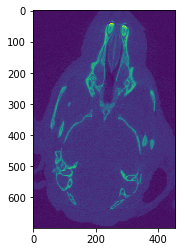

In [4]:
img_data = img.get_fdata()


def show_slices(slices):
    """Function to show image slices"""
    fig, axes = plt.subplot(1, len(slices), 1)
    i=0
    for  slice in slices:
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        i+=1

slice_0 = img_data[350, :, :]
slice_1 = img_data[:, 200, :]
slice_2 = img_data[:, :, 225]
#show_slices([slice_0, slice_1, slice_2])
# plt.suptitle("Center slices for EPI image")  # doctest: +SKIP


plt.imshow(slice_1)
plt.show()


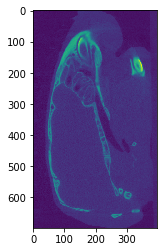

In [5]:
plt.imshow(slice_2)
plt.show()


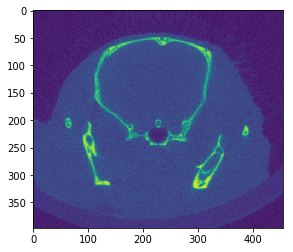

In [6]:
plt.imshow(slice_0)
plt.show()


The above images show three cross sections of the mouse skull.


In [7]:
import pandas as pd
from io import StringIO
from PreProcessing import tag_parser

In [8]:
tags = tag_parser('MouseSkullData/475_landmarks.tag')
tags

,x,y,z
0,13.652586,7.049266,14.942536
1,10.068154,9.493763,8.103688
2,9.732130,5.165423,0.571014
3,6.821619,9.391604,7.672170
4,1.929773,6.428143,13.676378


The 3D images are accompanied by `.tag` files that denote the `(x, y, z)` cordinates of key points measured in mm. There are currently only 4 points as initially we are only trying to orientate the mouse skulls in space.

---

To match these to the points on an our images we need to find out how large the voxels (3D pixles) are:


In [9]:
print("The voxel size is:", img.header.get_zooms(), 'mm in each dimension')

The voxel size is: (0.035, 0.035, 0.035) mm in each dimension


Therefore, we can divide the point location by the voxel size to get the points in space of the key points for this image.

In [35]:
pixel_loc = np.round(tags / 0.035)
pixel_loc

,x,y,z
0,390.0,201.0,427.0
1,288.0,271.0,232.0
2,278.0,148.0,16.0
3,195.0,268.0,219.0
4,55.0,184.0,391.0


When plotted on the skull image we can see that these points pertain to the left and right eyes, left and right front molars and the tip of the nose. 

These are used to orientate the skull in 3D space in order to make labeling easier.

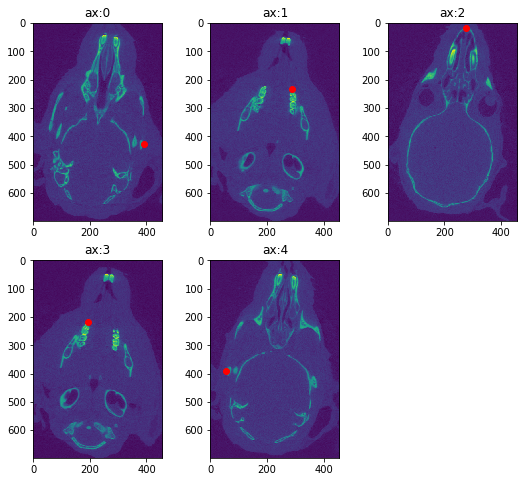

In [74]:
def mri_point_plot(img, df, dim_cols=['x', 'z'], iter_cols='y'):
    """Graphs an points. pt_cols is used to set the cols to iterate 
    over (different views)
    """
    
    ax = []
    fig = plt.figure(figsize=(9, 8))
    columns = 3
    rows = 2

    for i in df.index:
        y_slice = int(df.loc[i, iter_cols])
        im = img[:, y_slice, :]
        ax.append( fig.add_subplot(rows, columns, i+1))
        ax[-1].set_title("ax:"+str(i))  # set title
        plt.imshow(im)
        plt.plot(df.loc[i, dim_cols[0]], df.loc[i, dim_cols[1]], 'ro')
    plt.show()

mri_point_plot(img_data, pixel_loc, dim_cols=['x', 'z'])


Another example of a skull:

In [79]:
img2 = nib.load("MouseSkullData/4151.mnc")
tags2 = tag_parser("MouseSkullData/4151_landmarks.tag")



In [81]:
pix_size = img2.header.get_zooms()
print(pix_size)
img2 = img2.get_data()


(0.035, 0.035, 0.035)


In [83]:
tags2 = tags2 / pix_size[0]

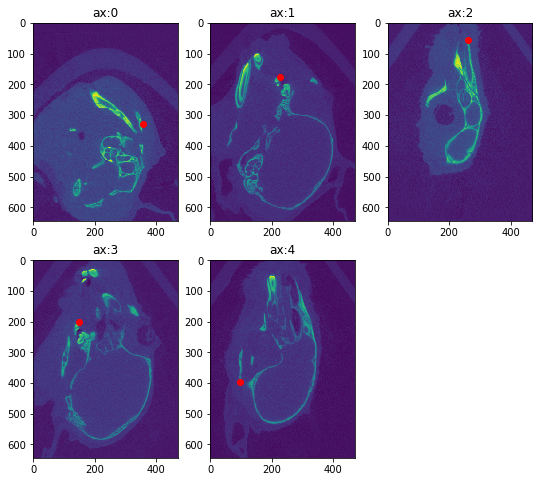

In [84]:
mri_point_plot(img2, tags2)

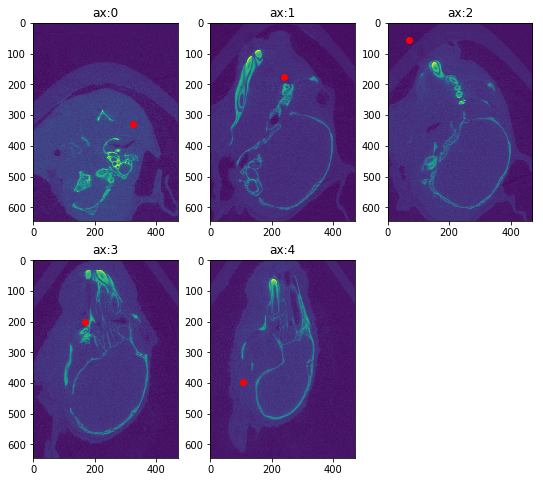

In [87]:
mri_point_plot(img2, tags2, ['y', 'z'], 'x')

# Explor image size
TODO

In [19]:
import sys
sys.getsizeof(img_data)

1010882816

In [59]:
print(round(sys.getsizeof(img_data) / 1e9, 2), "Gb")

1.01 Gb
